## 1. Configuration

In [1]:
import  numpy               as      np
import  torch
from    torch               import  nn
from    torch.utils.data    import  DataLoader

from    utils      import  *
from    deep_svdd  import  *

from    tqdm.notebook   import  trange
from    matplotlib      import  pyplot  as  plt


device = torch.device('cuda:2')

In [2]:
BATCH_SIZE      = 1024
LR              = 1e-3
LR_AE           = 1e-3
LR_MILESTONES   = [50]
NUM_EPOCHS      = 75
NUM_EPOCHS_AE   = 150
WEIGHT_DECAY    = 5e-7
WEIGHT_DECAY_AE = 5e-3

NORMAL_CLASS    = 0

## 2. Pretrain the encoder

In [3]:
train_dataset   = Dataset_MNIST(BASE_PATHS[MNIST]/"train.npz", NORMAL_CLASS)
test_dataset    = Dataset_MNIST(BASE_PATHS[MNIST]/"test.npz",  NORMAL_CLASS)
train_loader    = DataLoader(train_dataset, BATCH_SIZE)
test_loader     = DataLoader(test_dataset, BATCH_SIZE)

In [4]:
model_ae        = ConvAutoEncoder_MNIST(device)
mse_loss_ae     = torch.nn.MSELoss(reduction="mean")
optimizer_ae    = torch.optim.Adam(model_ae.parameters(), LR_AE, weight_decay=WEIGHT_DECAY_AE)
scheduler_ae    = torch.optim.lr_scheduler.MultiStepLR(optimizer_ae, LR_MILESTONES, gamma=0.1)
list_loss_ae:   list[float] = []


model_ae.train()
for epoch in trange(1, 1+NUM_EPOCHS_AE):
    avg_loss_ae = 0
    for data, _ in train_loader:
        data = data.to(device)
        
        reconst = model_ae.forward(data)
        loss_ae = mse_loss_ae.forward(reconst, data)
        optimizer_ae.zero_grad()
        loss_ae.backward()
        optimizer_ae.step()
        
        avg_loss_ae += loss_ae.item()*data.size(0)
    avg_loss_ae /= len(train_dataset)
    list_loss_ae.append(avg_loss_ae)
    scheduler_ae.step()
    
    if epoch%5==0 or epoch==1:
        print(f"Epoch {epoch:03d} >>> Train loss {avg_loss_ae:.4e}")
list_loss_ae = torch.tensor(list_loss_ae)

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001 >>> Train loss 1.3946e-01
Epoch 005 >>> Train loss 6.0168e-02
Epoch 010 >>> Train loss 4.7855e-02
Epoch 015 >>> Train loss 3.7541e-02
Epoch 020 >>> Train loss 3.0234e-02
Epoch 025 >>> Train loss 2.5389e-02
Epoch 030 >>> Train loss 2.2038e-02
Epoch 035 >>> Train loss 1.9785e-02
Epoch 040 >>> Train loss 1.9182e-02
Epoch 045 >>> Train loss 1.7739e-02
Epoch 050 >>> Train loss 1.7591e-02
Epoch 055 >>> Train loss 1.6425e-02
Epoch 060 >>> Train loss 1.6301e-02
Epoch 065 >>> Train loss 1.6197e-02
Epoch 070 >>> Train loss 1.6100e-02
Epoch 075 >>> Train loss 1.6002e-02
Epoch 080 >>> Train loss 1.5901e-02
Epoch 085 >>> Train loss 1.5797e-02
Epoch 090 >>> Train loss 1.5687e-02
Epoch 095 >>> Train loss 1.5580e-02
Epoch 100 >>> Train loss 1.5470e-02
Epoch 105 >>> Train loss 1.5365e-02
Epoch 110 >>> Train loss 1.5263e-02
Epoch 115 >>> Train loss 1.5162e-02
Epoch 120 >>> Train loss 1.5065e-02
Epoch 125 >>> Train loss 1.4970e-02
Epoch 130 >>> Train loss 1.4874e-02
Epoch 135 >>> Train loss 1.4

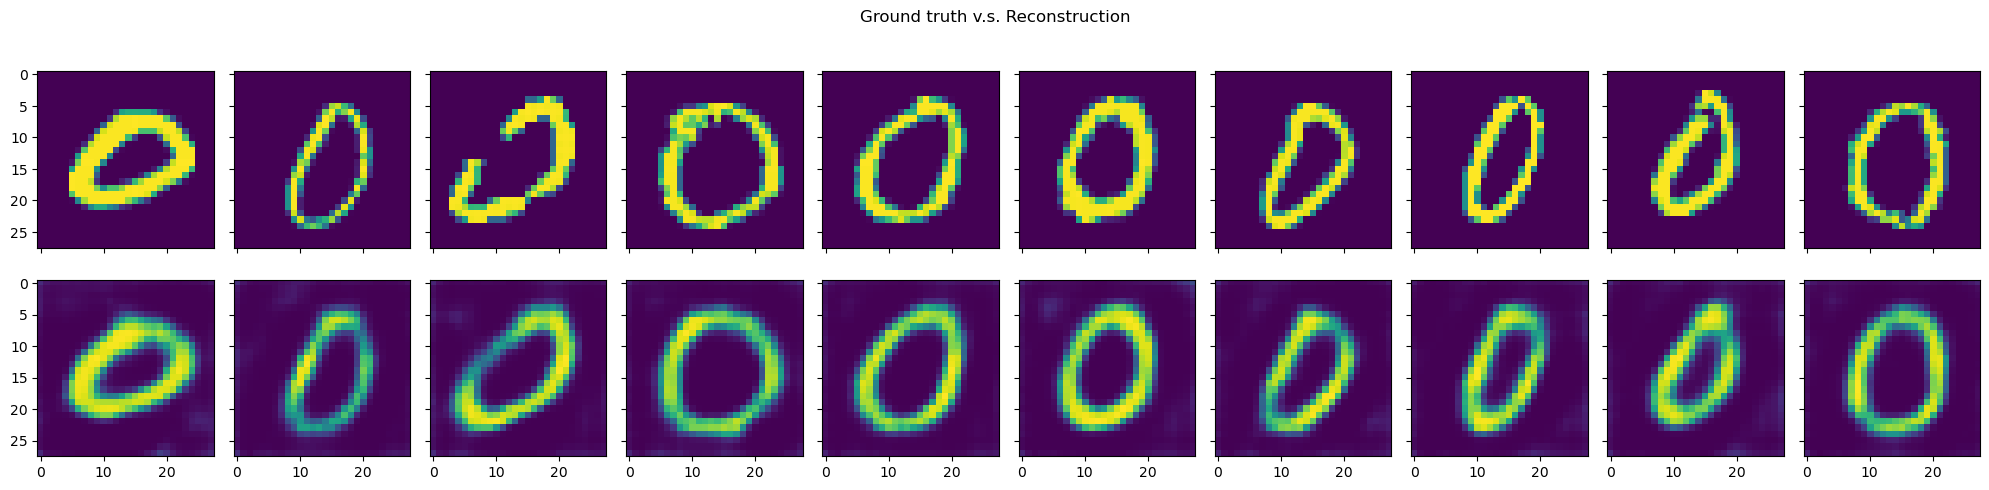

In [5]:
reconstruction = []
model_ae.eval()
with torch.inference_mode():
    for data, _ in test_loader:
        data = data.to(device)
        reconst = model_ae.forward(data).detach().cpu()
        reconstruction.append(reconst)
reconstruction = torch.cat(reconstruction, dim=0)


fig, axes = plt.subplots(2, 10, figsize=(20, 5), sharex=True, sharey=True)
fig.suptitle("Ground truth v.s. Reconstruction")

indices = torch.randint(0, len(test_dataset), (10,))
for c, idx in enumerate(indices):
    axes[0][c].imshow(test_dataset[idx][0].squeeze())
    axes[1][c].imshow(reconstruction[idx].squeeze())
fig.tight_layout()
fig.show()

In [6]:
model_ae.cpu()
torch.save(model_ae.state_dict(), "deep_svdd__pretrained_model.pth")
del(train_dataset, train_loader, test_dataset, test_loader)

## 3. Train and test Deep SVDD

In [7]:
train_dataset   = Dataset_MNIST(BASE_PATHS[MNIST]/"train.npz", NORMAL_CLASS)
test_dataset    = Dataset_MNIST(BASE_PATHS[MNIST]/"test.npz")
train_loader    = DataLoader(train_dataset, BATCH_SIZE)
test_loader     = DataLoader(test_dataset, BATCH_SIZE)

In [8]:
model = DeepSVDD(model_ae.encoder, True, nu=5e-2, C=1e-3, device=device)
optimizer   = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
scheduler   = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=LR_MILESTONES, gamma=0.1)
list_loss:  list[float] = []

for epoch in trange(1, 1+NUM_EPOCHS):
    avg_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        if model.svdd_center is None:
            model.compute_svdd_center(data)
        data = data.to(device)
        loss = model.loss__one_class(data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()*data.size(0)
    avg_loss /= len(train_dataset)
    list_loss.append(avg_loss)
    scheduler.step()
    
    if epoch%5==0 or epoch==1:
        print(f"Epoch {epoch:03d} >>> Train loss {avg_loss:.4e}")
list_loss = torch.tensor(list_loss)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 001 >>> Train loss 5.4109e-01
Epoch 005 >>> Train loss 5.3078e-02
Epoch 010 >>> Train loss 1.4331e-02
Epoch 015 >>> Train loss 8.3218e-03
Epoch 020 >>> Train loss 6.1189e-03
Epoch 025 >>> Train loss 4.7860e-03
Epoch 030 >>> Train loss 3.8690e-03
Epoch 035 >>> Train loss 3.2458e-03
Epoch 040 >>> Train loss 2.8381e-03
Epoch 045 >>> Train loss 2.5416e-03
Epoch 050 >>> Train loss 2.3273e-03
Epoch 055 >>> Train loss 2.2794e-03
Epoch 060 >>> Train loss 2.2608e-03
Epoch 065 >>> Train loss 2.2418e-03
Epoch 070 >>> Train loss 2.2224e-03
Epoch 075 >>> Train loss 2.2027e-03


In [12]:
model.eval()
prediction = []
ground_truth = []
with torch.inference_mode():
    for data, target in test_loader:
        ground_truth.append(torch.where(target==NORMAL_CLASS, 1, 0))
        prediction.append(model.forward(data.to(device)).cpu())
prediction = torch.cat(prediction, dim=0)
ground_truth = torch.cat(ground_truth, dim=0)

print(f"Accuracy >>> {torch.mean(torch.where(prediction==ground_truth, 1.0, 0.0)).item():.4f}")

Accuracy >>> 0.9020


End of file